In [41]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import poisson

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import MultipleLocator, MaxNLocator
import matplotlib.gridspec as gridspec
import seaborn as sns

import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.tensor.special import gammaln

from tqdm.autonotebook import tqdm

plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "legend.fontsize": 12,
    "legend.title_fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 18,
})
mpl.rcParams['animation.embed_limit'] = 2000


## Generate the synthetic data

In [42]:
class insilico_experiment:
    """
        Parameters to be estimated in subsequent Bayesian inference:
        1. the average lambda (kill_lambda_avg)
        2. the std of lambda (kill_lambda_sd)
        3. the proportion of the non-killers (p_zero)
    """
    def __init__(
        self,
        kill_lambda_avg: float = 3.0,
        kill_lambda_sd: float = 1.0,
        lambda_dis_mode: str = "normal",  # "gamma", "lognormal", "normal", "halfnormal"
        Num_killers_obs: int = 300,
        random_seed: int = 66
    ):
        self.kill_lambda_avg = kill_lambda_avg
        self.kill_lambda_sd = kill_lambda_sd
        self.lambda_dis_mode = lambda_dis_mode
        self.Num_killers_obs = Num_killers_obs
        self.random_seed = random_seed
        
        self.lambdas, self.kills = self._generate_data()
    
    def _generate_data(self):
        rng = np.random.default_rng(self.random_seed)
        if self.lambda_dis_mode == "gamma":
            shape = self.kill_lambda_avg**2 / self.kill_lambda_sd**2
            scale = self.kill_lambda_sd**2 / self.kill_lambda_avg
            lambdas = rng.gamma(shape, scale, self.Num_killers_obs)
        elif self.lambda_dis_mode == "lognormal":
            sigma2_log = np.log(1 + (self.kill_lambda_sd / self.kill_lambda_avg)**2)
            mu_log = np.log(self.kill_lambda_avg) - 0.5 * sigma2_log
            lambdas = rng.lognormal(mean=mu_log, sigma=np.sqrt(sigma2_log), size=self.Num_killers_obs)
        elif self.lambda_dis_mode == "normal":
            lambdas = rng.normal(self.kill_lambda_avg, self.kill_lambda_sd, self.Num_killers_obs)
            lambdas = np.clip(lambdas, 0, None)
        elif self.lambda_dis_mode == "halfnormal":
            # match_by: str = "mean"   
            # if match_by == "mean":
            sigma = self.kill_lambda_avg * np.sqrt(np.pi / 2.0)
            # elif match_by == "sd":
            #     sigma = self.kill_lambda_sd / np.sqrt(1.0 - 2.0/np.pi)
            # else:
            #     raise ValueError("match_by must be 'mean' or 'sd'")
            lambdas = np.abs(rng.normal(0.0, sigma, self.Num_killers_obs))  # draw |N(0, sigma^2)|
        else:
            raise ValueError("lambda_dis_mode must be 'gamma', 'lognormal', 'normal', or 'halfnormal'")
        

        kills = rng.poisson(lambdas)

        return lambdas, kills
    
    def regenerate(self, new_seed: int = None):
        if new_seed is not None:
            self.random_seed = new_seed
        self.lambdas, self.kills = self._generate_data()
        
    def get_summary(self):
        return {
            "kill_lambda_avg": self.kill_lambda_avg,
            "kill_lambda_sd": self.kill_lambda_sd,
            "lambdas": self.lambdas,
            "kills": self.kills,
            "killer_number": self.Num_killers_obs
        }


In [43]:
NO_CELL = 10000


lambda_avg_list = [0.5, 1.2, 2]
lambda_sd_list = [0.05, 0.2, 0.4]
cell_num_list = [NO_CELL, NO_CELL, NO_CELL]


experiment = {}
for i, lambda_avg in enumerate(lambda_avg_list):
    lambda_sd = lambda_sd_list[i]

    experiment[i] = insilico_experiment(
        kill_lambda_avg=lambda_avg,
        kill_lambda_sd=lambda_sd,
        lambda_dis_mode="gamma",
        Num_killers_obs=cell_num_list[i],
        random_seed=66
    )

/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_69930/2983531003.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('YlGnBu')


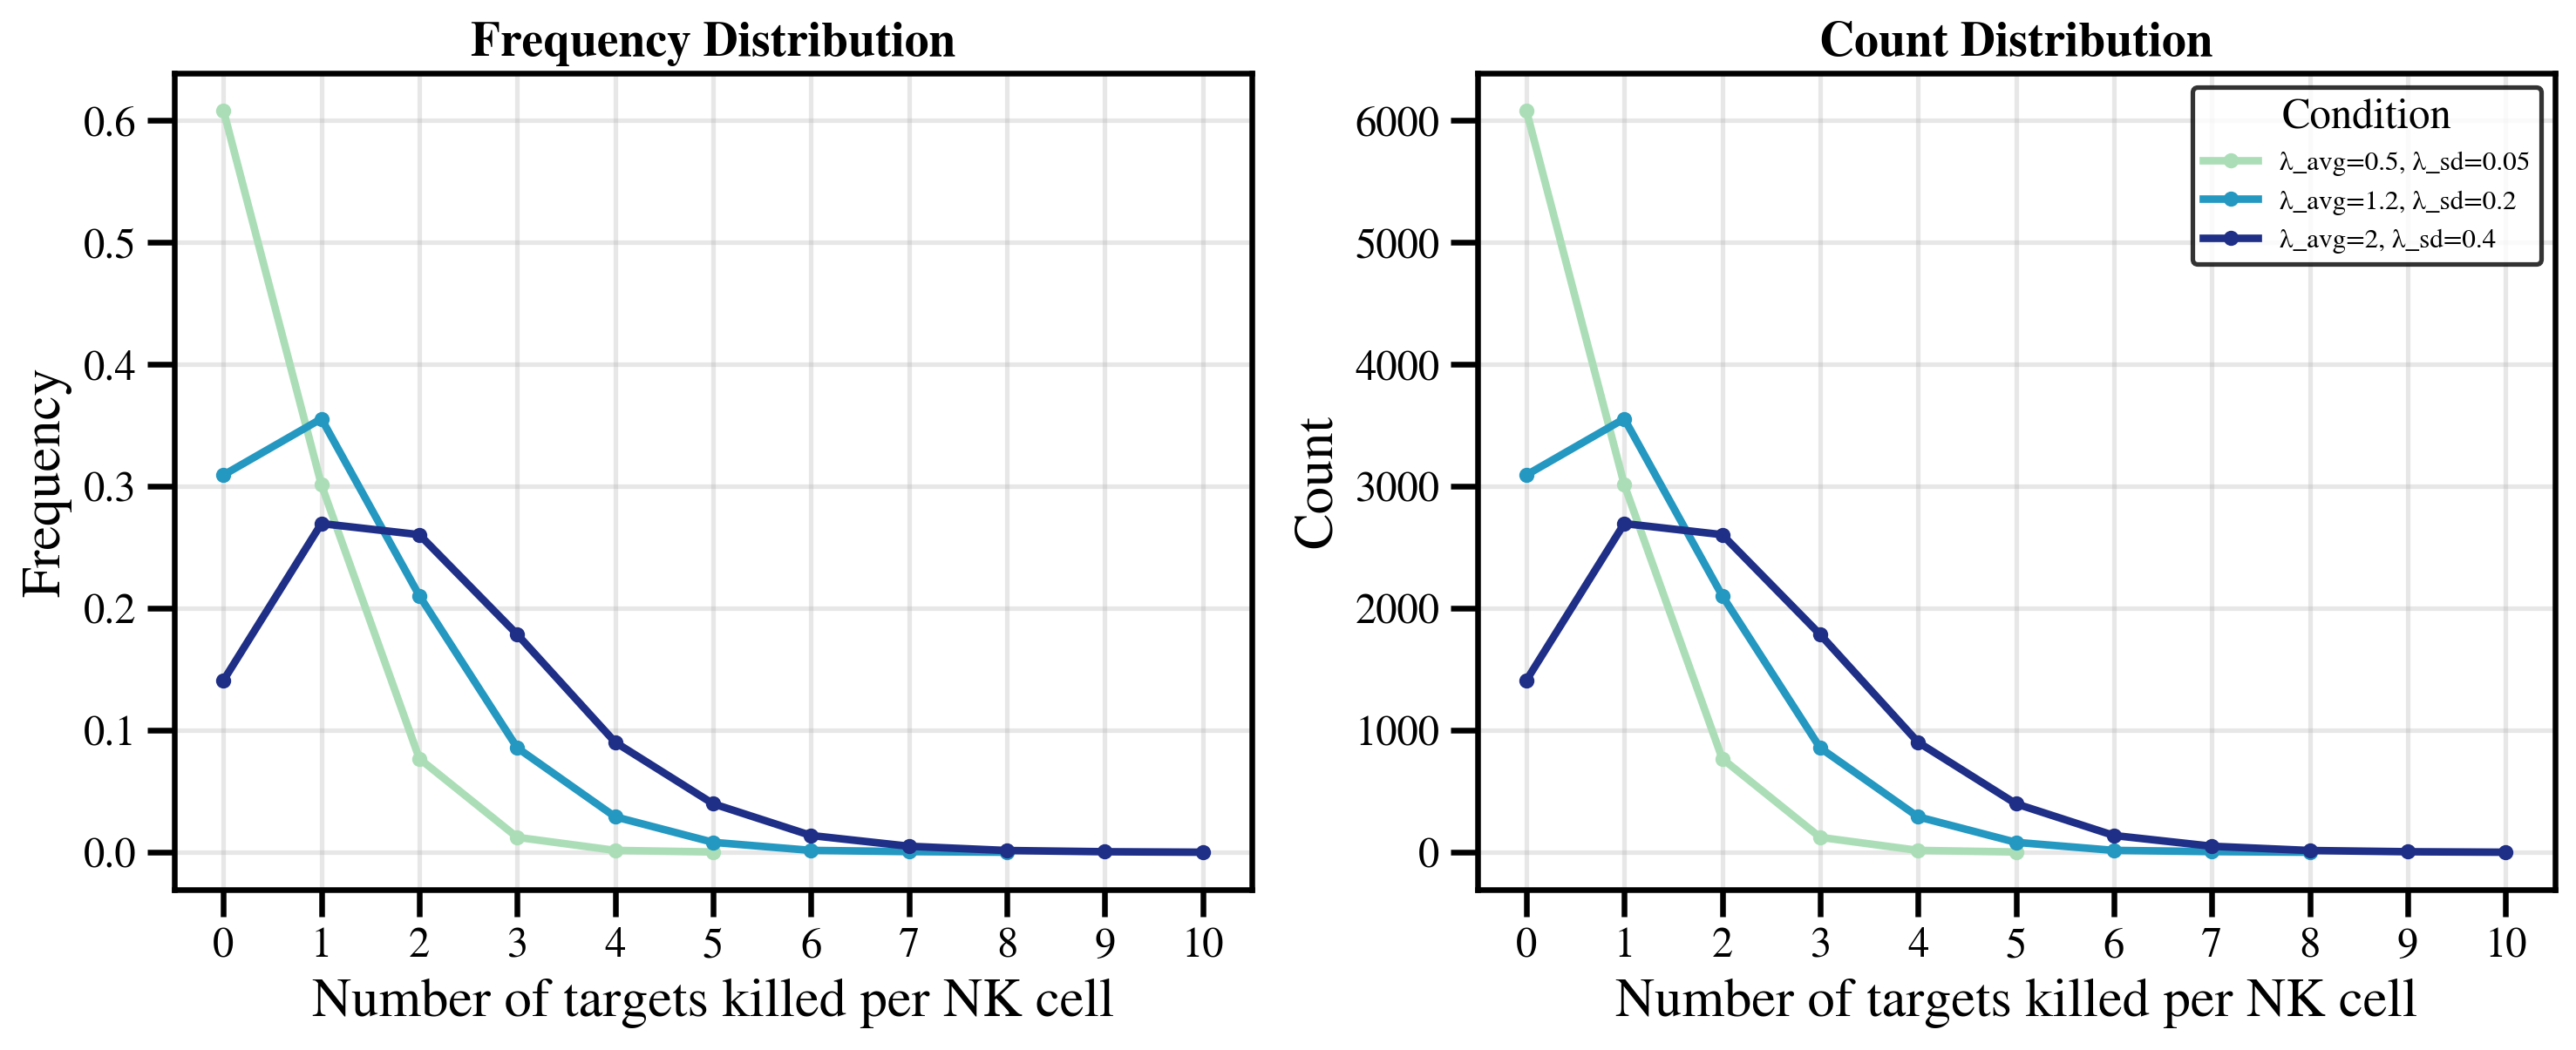

In [44]:
conditions = [
    f"λ_avg={lambda_avg_list[i]}, λ_sd={lambda_sd_list[i]}" 
    for i in range(len(lambda_avg_list))
]

cmap = get_cmap('YlGnBu')
colors = cmap(np.linspace(0.3, 0.9, len(conditions)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=250, sharex=True)
ax_freq, ax_count = axes

for i, cond_name in enumerate(conditions):
    colour = colors[i]
    
    kills = experiment[i].get_summary()['kills']
    n_cells = len(kills)
    max_kills = int(kills.max())
    counts = np.bincount(kills, minlength=max_kills + 1)
    freq = counts / n_cells if n_cells > 0 else np.zeros_like(counts)
    x = np.arange(len(counts))
    
    ax_freq.plot(x, freq, color=colour, linewidth=2.5, label=cond_name, marker='o', markersize=4)
    ax_count.plot(x, counts, color=colour, linewidth=2.5, label=cond_name, marker='o', markersize=4)

ax_freq.set_title("Frequency Distribution", fontweight='bold')
ax_count.set_title("Count Distribution", fontweight='bold')
ax_freq.set_ylabel("Frequency")
ax_count.set_ylabel("Count")

for ax in (ax_freq, ax_count):
    ax.set_xlabel("Number of targets killed per NK cell")
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.grid(True, alpha=0.3)

ax_count.legend(title="Condition", frameon=True, edgecolor='black', loc='upper right', fontsize=9)
plt.tight_layout()
# plt.savefig("./synthetic_data_plots.pdf", dpi=500, bbox_inches="tight")
plt.show()


In [45]:
summary_data = []

for i in range(len(experiment)):
    exp = experiment[i]
    kills = exp.kills
    lambdas = exp.lambdas
    
    summary_data.append({
        'Experiment': i,
        'λ_avg (input)': exp.kill_lambda_avg,
        'λ_sd (input)': exp.kill_lambda_sd,
        'λ_mean (actual)': np.mean(lambdas),
        'λ_std (actual)': np.std(lambdas),
        'Kills_mean': np.mean(kills),
        'Kills_std': np.std(kills),
        'Kills_min': np.min(kills),
        'Kills_max': np.max(kills),
        'Zero_kills (%)': 100 * np.sum(kills == 0) / len(kills),
    })

df_summary = pd.DataFrame(summary_data)
print("Summary Statistics for Synthetic Experiments:")
print("=" * 120)
print(df_summary.to_string(index=False))
print("=" * 120)


Summary Statistics for Synthetic Experiments:
 Experiment  λ_avg (input)  λ_sd (input)  λ_mean (actual)  λ_std (actual)  Kills_mean  Kills_std  Kills_min  Kills_max  Zero_kills (%)
          0            0.5          0.05         0.500284        0.050287      0.4996   0.708943          0          5           60.78
          1            1.2          0.20         1.201136        0.201326      1.2047   1.131193          0          8           30.92
          2            2.0          0.40         2.002394        0.402659      2.0206   1.469958          0         10           14.09


## Bayesian Inference

In [46]:
def inference_one(kills_per_cell, draws=3000, tune=3000, chains=6, seed=66):
    M = len(kills_per_cell)
    with pm.Model() as model:
        eta = pm.Uniform("eta", lower=-1.0, upper=1.0)
        mu_lambda = pm.Deterministic("mu_lambda", 10.0 ** eta)
        sigma_lambda = pm.HalfNormal("sigma_lambda", sigma=1)
        # sigma_lambda = pm.HalfCauchy("sigma_lambda", beta=0.5)
        alpha = pm.Deterministic("alpha", (mu_lambda / sigma_lambda) ** 2)
        beta = pm.Deterministic("beta", sigma_lambda ** 2 / mu_lambda)
        lambda_group = pm.Gamma("lambda_group", alpha=alpha, beta=1.0 / beta, shape=M)
        pm.Poisson(
            "kills", mu=lambda_group, observed=kills_per_cell
        )
        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            target_accept=0.95,
            random_seed=seed,
            progressbar=True,
        )
        try:
            trace = pm.compute_log_likelihood(trace, extend_inferencedata=True)
        except Exception:
            pass
    return trace

def inference_one_nb(kills_per_cell, draws=3000, tune=3000, chains=6, seed=66, exposure=None):
    import numpy as np, pymc as pm
    y = np.asarray(kills_per_cell, dtype=int)
    if exposure is None:
        exposure = np.ones_like(y, dtype=float)

    with pm.Model() as model:
        eta = pm.Uniform("eta", lower=-1.0, upper=1.0)
        mu_lambda = pm.Deterministic("mu_lambda", 10.0 ** eta)
        sigma_lambda = pm.HalfNormal("sigma_lambda", sigma=1.0)
        
        alpha = pm.Deterministic("alpha", (mu_lambda / sigma_lambda) ** 2)
        beta_rate = pm.Deterministic("beta_rate", mu_lambda / sigma_lambda**2)
        mu_i = pm.Deterministic("mu_i", (alpha / beta_rate) * exposure)

        pm.NegativeBinomial("kills", mu=mu_i, alpha=alpha, observed=y)

        trace = pm.sample(
            draws=draws, tune=tune, chains=chains,
            target_accept=0.95, random_seed=seed)
    return trace

def inference_all(
    experiment,
    labels=None,
    draws=3000,
    tune=3000,
    chains=4,
    seed=None
):
    if labels is None:
        labels = [f"cond_{i}" for i in range(len(experiment))]

    out = []
    for i in tqdm(range(len(experiment))):
        current_seed = seed + i if seed is not None else None
        idata = inference_one_nb(
            kills_per_cell=experiment[i].get_summary()['kills'],
            draws=draws,
            tune=tune,
            chains=chains,
            seed=current_seed
        )
        out.append((labels[i], idata))
    return out

In [47]:
conditions = [
    f"λ_avg={lambda_avg_list[i]}, λ_sd={lambda_sd_list[i]}" 
    for i in range(len(lambda_avg_list))
]
ground_truth_values = {}
for i, cond_label in enumerate(conditions):
    ground_truth_values[cond_label] = {
        "mu_lambda": experiment[i].kill_lambda_avg,
        "sigma_lambda": experiment[i].kill_lambda_sd
    }   


idatas = inference_all(
    experiment=list(experiment.values()),
    labels=conditions,
    draws=3000,
    tune=3000,
    chains=4,
    # seed=66
)

  0%|          | 0/3 [00:00<?, ?it/s]Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, sigma_lambda]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 297 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
 33%|███▎      | 1/3 [04:57<09:55, 297.79s/it]Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, sigma_lambda]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 9 seconds.
 67%|██████▋   | 2/3 [05:07<02:08, 128.16s/it]Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, sigma_lambda]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 9 seconds.
100%|██████████| 3/3 [05:16<00:00, 105.60s/it]


/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_69930/2407322178.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


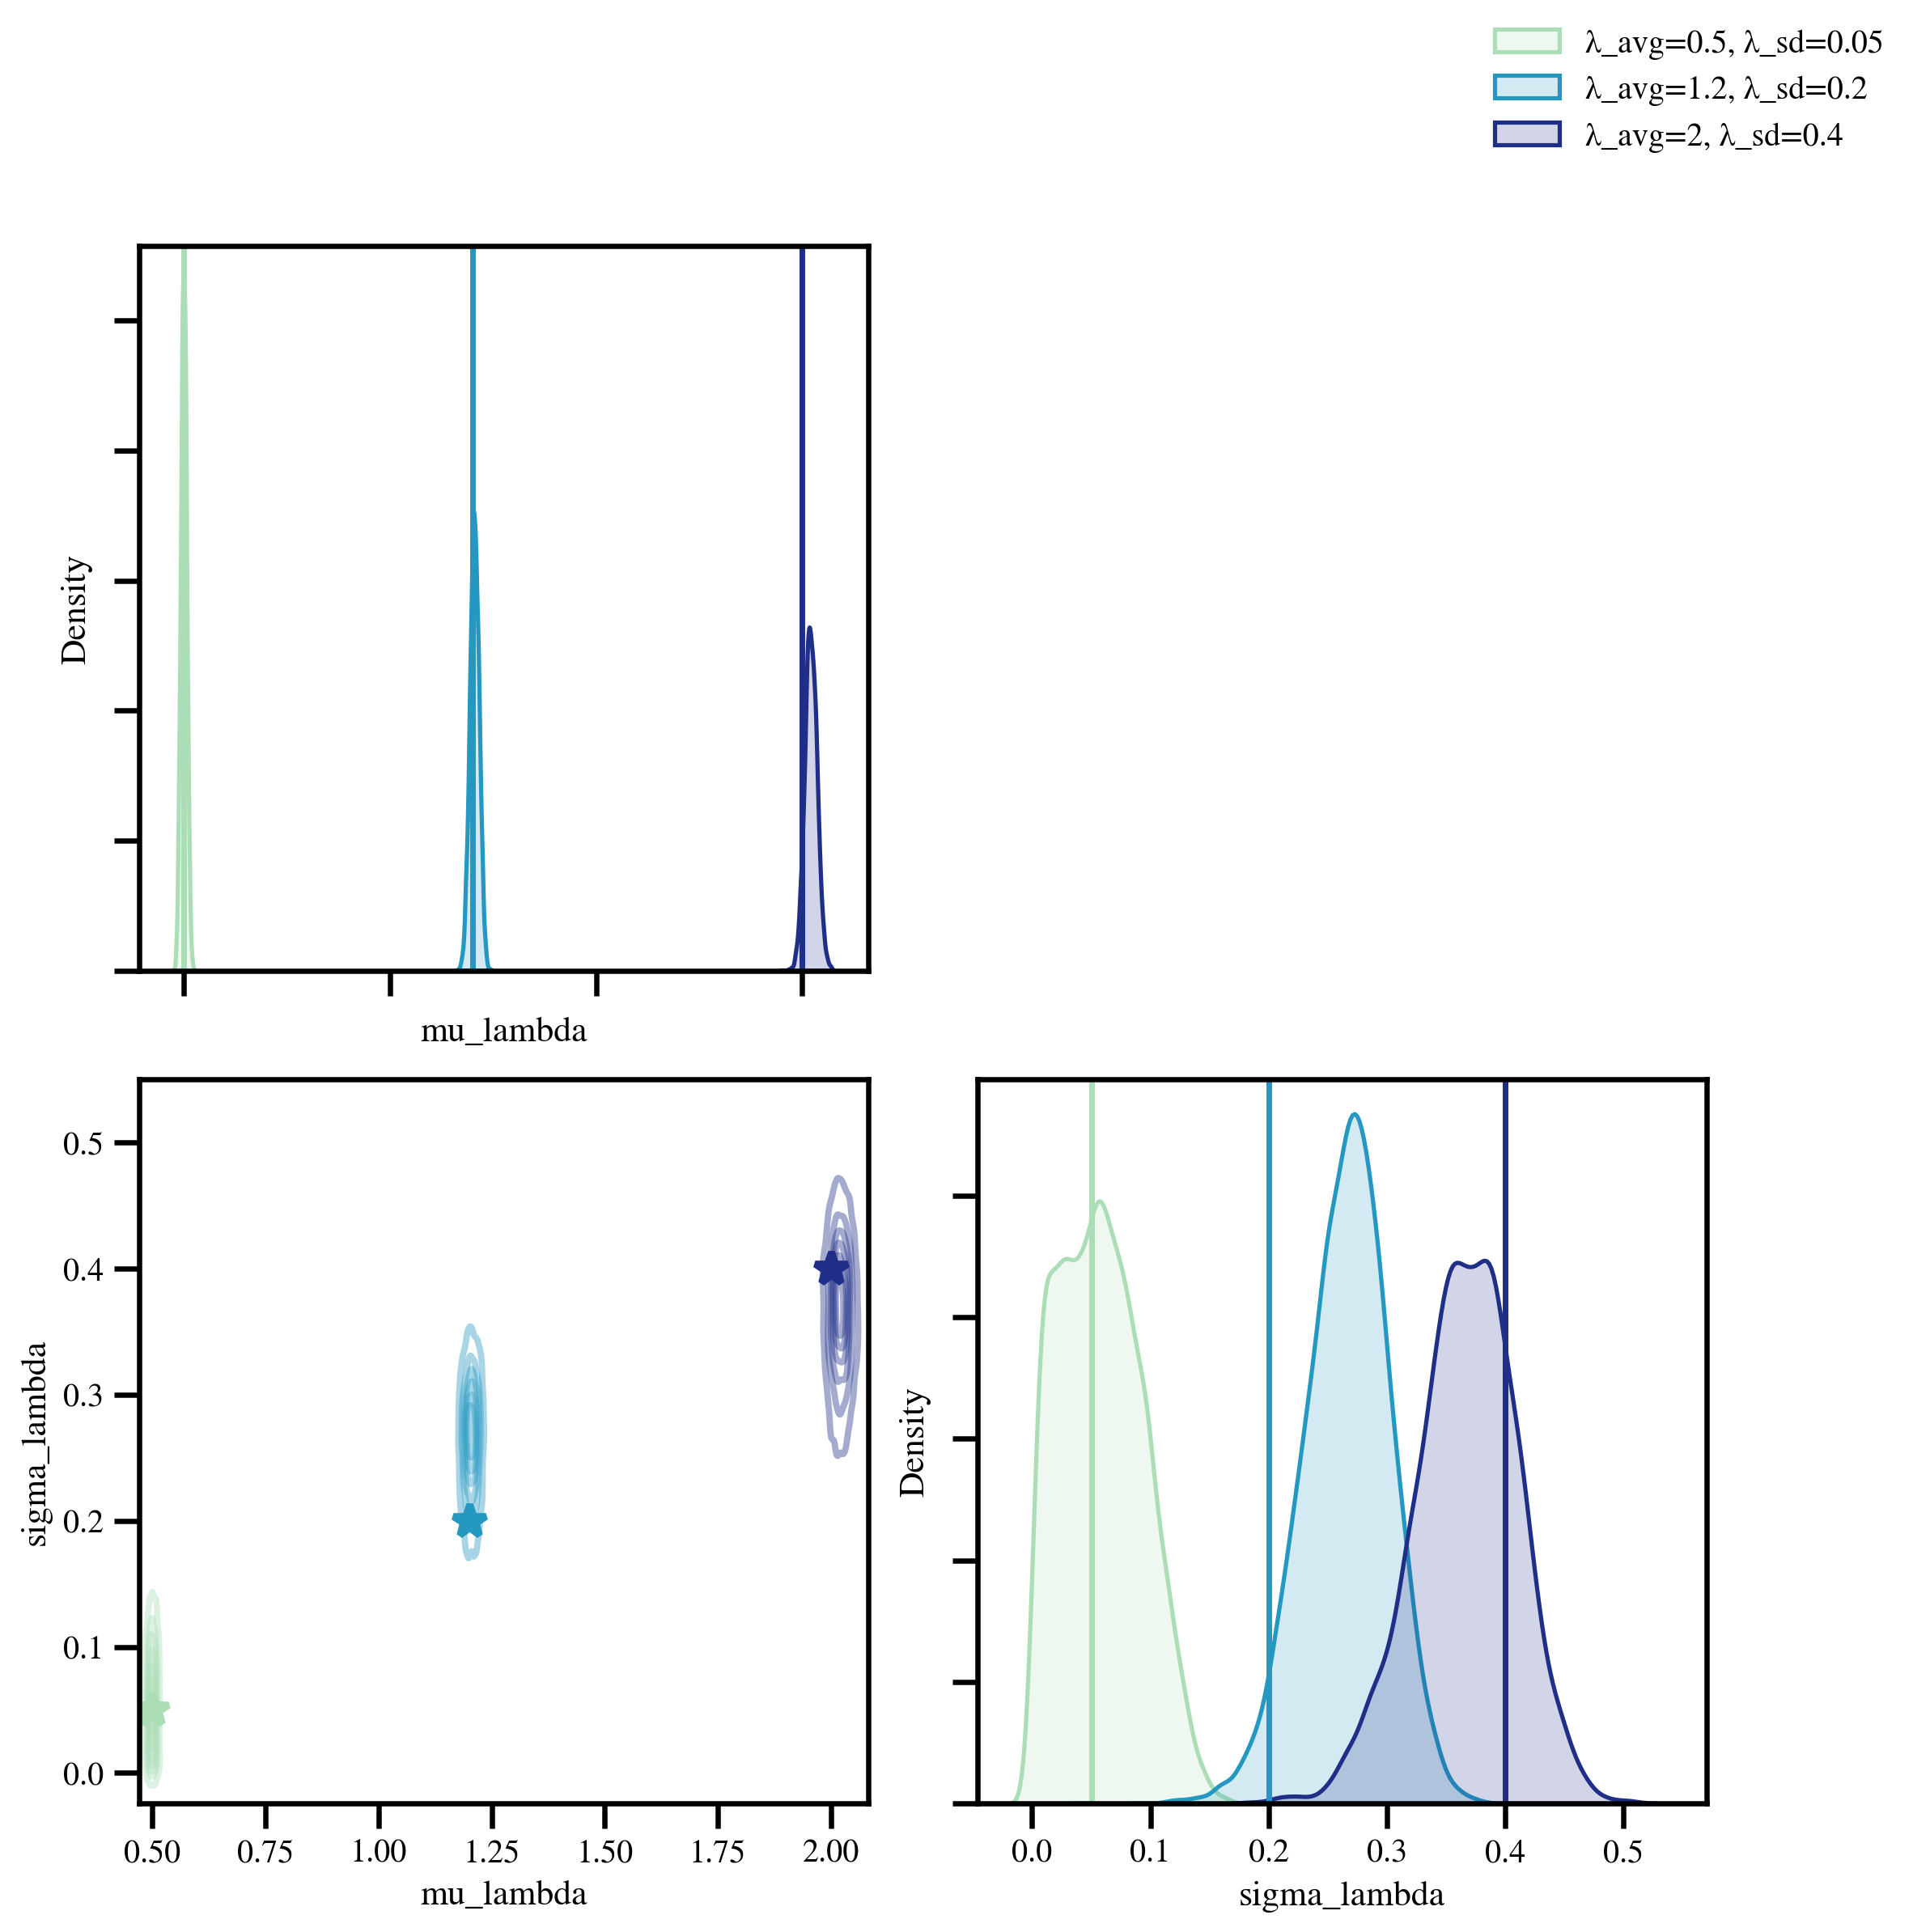

In [48]:
def plot_joint_posteriors(
    idatas,
    ground_truth=None,
    parameters=None,
    hdi_prob=0.95,
    sample_size=6000,
    save_pdf=False,
    pdf_path="joint_posteriors.pdf",
    cmap_name="YlGnBu",
    point_size=3,
    font_scale=0.7,
):
    sns.set_context("talk", font_scale=font_scale)
    cmap = plt.colormaps.get_cmap(cmap_name)
    colors = cmap(np.linspace(0.3, 0.9, len(idatas)))
    label_to_df = {}
    for label, idata in idatas:
        posterior = idata.posterior
        if parameters is None:
            parameters = [v for v in posterior.data_vars if posterior[v].ndim <= 2]
        df = pd.DataFrame()
        for p in parameters:
            vals = posterior[p].stack(sample=("chain", "draw")).values.ravel()
            if len(vals) > sample_size:
                vals = np.random.choice(vals, sample_size, replace=False)
            df[p] = vals
        df["label"] = label
        label_to_df[label] = df
    npar = len(parameters)
    fig = plt.figure(figsize=(5 * npar, 5 * npar), dpi = 250)
    gs = gridspec.GridSpec(npar, npar, wspace=0.15, hspace=0.15)
    gaxes = np.empty((npar, npar), dtype=object)
    for irow, rowpar in enumerate(parameters):
        for icol, colpar in enumerate(parameters):
            ax = plt.subplot(gs[irow, icol])
            gaxes[irow, icol] = ax
            if icol > irow:
                ax.axis("off")
                continue
            for color, (label, df) in zip(colors, label_to_df.items()):
                if icol == irow:
                    sns.kdeplot(
                        df[rowpar], ax=ax,
                        fill=True, color=color,
                        alpha=0.2, linewidth=1.5,
                        label=label if irow == 0 else None,
                    )
                    if ground_truth is not None and label in ground_truth and rowpar in ground_truth[label]:
                        ax.axvline(ground_truth[label][rowpar], color=color, linestyle='-', linewidth=2)
                else:
                    sns.kdeplot(
                        x=df[colpar],
                        y=df[rowpar],
                        ax=ax, fill=False,
                        color=color, alpha=0.4,
                        levels=7,
                    )
                    if ground_truth and label in ground_truth:
                        if colpar in ground_truth[label] and rowpar in ground_truth[label]:
                            ax.plot(ground_truth[label][colpar], ground_truth[label][rowpar], 
                                    marker='*', color=color, markersize=12, markeredgewidth=2.5, linestyle='None')
            if irow == npar - 1:
                ax.set_xlabel(colpar)
            else:
                ax.set_xticklabels([])
            if icol == 0 and irow != 0:
                ax.set_ylabel(rowpar)
            else:
                ax.set_yticklabels([])
    handles, labels = gaxes[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper right", frameon=False)
    plt.tight_layout()
    if save_pdf:
        plt.savefig(pdf_path, dpi=300, bbox_inches="tight")
        print(f"Saved joint posterior plot: {pdf_path}")
    plt.show()

plot_joint_posteriors(
    idatas,
    ground_truth=ground_truth_values,
    parameters=["mu_lambda", "sigma_lambda"],
    hdi_prob=0.95,
    sample_size=6000,
    # save_pdf=True,
    # pdf_path="joint_posteriors.pdf"
)